In [1]:
%matplotlib inline
'''
How to Optimize Your Dragon: V1
Import initialized model and start the optimization
'''
# system imports
import sys
import os
import datetime
sys.path.append(os.path.abspath('..'))
sys.path.append(os.path.abspath('../..'))

import numpy as np
from matplotlib import pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

import dill

# pyomo imports
from pyomo import environ as pe
from global_sets.component import m

from stages.reactive_stage import reactive_stage_rule
from stages.condenser_stage import condenser_stage_rule
from stages.reboiler_stage import reboiler_stage_rule

from utility.display_utility import beautify, beautify_reactive, HiddenLogs, HiddenPrints, plot_distribution,\
                                    trans_cnumber, trans_product_mole, check_product_spec
from utility.model_utility import add_dual, update_dual, delete_dual, check_DOF, tray_translator, check_iteration# , check_violate_constraint
from utility.data_utility import cal_cnumber
from utility.time_utility import create_filename_time, log_now, log_end

2018-07-18 15:50:07 - Start Program


In [2]:
logname = create_filename_time()
log_text_dir = './log/text/opt_'+logname+'.dat'
log_figure_dir = './log/figure/opt_'+logname+'.pdf'

In [3]:
with open('./log/model/stage_20_base_product.pickle','rb') as f:
    model = dill.load(f)

In [4]:
check_DOF(pe,model)

Active Equality Constraints:	 28997
Active Inequality Constraints:	 21
Active Variables:		 29462
Fixed Variables:		 392
DOF:				 73


# Add tray optimization related sets and variables

In [5]:
model.TRAY_total = pe.Set(initialize=['condenser']+[str(i) for i in model.TRAY]+['reboiler'])
model.TRAY_total.ordered = True

In [6]:
model.P_tray = pe.Var(model.TRAY_total,m.PRODUCT,within=pe.NonNegativeReals,initialize=0)
model.P_total = pe.Var(m.PRODUCT,within=pe.NonNegativeReals,initialize=0)
model.P_total_dry = pe.Var(m.PRODUCT,within=pe.NonNegativeReals,initialize=0)
model.x_P = pe.Var(m.COMP_TOTAL,m.PRODUCT,within=pe.NonNegativeReals,bounds=(0,1))
model.x_P_dry = pe.Var(m.COMP_ORG,m.PRODUCT,within=pe.NonNegativeReals,bounds=(0,1))

# Add equations

In [7]:
# sum of liquid draw for all products for each stage
def stage_sum_product_rule(model,j):
    return tray_translator(model,j).L['P'] == sum(model.P_tray[j,p] for p in m.PRODUCT)
model.stage_sum_product_con = pe.Constraint(model.TRAY_total,rule=stage_sum_product_rule)

# liquid product mass balance
def product_sum_stage_rule(model,p):
    return model.P_total[p] == sum(model.P_tray[j,p] for j in model.TRAY_total)
model.product_sum_stage_con = pe.Constraint(m.PRODUCT,rule=product_sum_stage_rule)

# liquid product component mass balance
def mass_balance_product_rule(model,i,p):
    return sum(model.P_tray[j,p]*tray_translator(model,j).x[i] for j in model.TRAY_total) == model.P_total[p]*model.x_P[i,p]
model.mass_balance_product_con = pe.Constraint(m.COMP_TOTAL,m.PRODUCT,rule=mass_balance_product_rule)

In [8]:
# dry liquid product component 
def product_sum_dry_rule(model,p):
    return model.P_total_dry[p] == model.P_total[p] * (1 - sum(model.x_P[i,p] for i in m.COMP_INORG))
model.product_sum_dry_con = pe.Constraint(m.PRODUCT,rule=product_sum_dry_rule)

# dry liquid product component mass balance
def mass_balance_dry_rule(model,i,p):
    return model.x_P_dry[i,p] * (1 - sum(model.x_P[i,p] for i in m.COMP_INORG)) == model.x_P[i,p]
model.mass_balance_dry_con = pe.Constraint(m.COMP_ORG,m.PRODUCT,rule=mass_balance_dry_rule)

# Transfer from original liquid side-draw variable to product variable

### Transfer fixed side-draw variables

In [9]:
model.reactive[:].PR_L.unfix();
model.P_tray[:,:].fix(0)
model.P_tray['condenser','naphtha'].unfix(); model.P_tray['condenser','naphtha'].set_value(model.condenser.L['P'].value)
model.P_tray['4','intermediate'].fix(model.reactive[4].L['P'].value)
model.P_tray['7','gasoline'].fix(model.reactive[7].L['P'].value)
model.P_tray['10','diesel'].fix(model.reactive[10].L['P'].value)
model.P_tray['reboiler','heavy'].unfix(); model.P_tray['reboiler','heavy'].set_value(model.reboiler.L['P'].value)

### Initialized newly created value

In [10]:
model.P_total['naphtha'].set_value(model.P_tray['condenser','naphtha'].value)
model.P_total['intermediate'].set_value(model.P_tray['4','intermediate'].value)
model.P_total['gasoline'].set_value(model.P_tray['7','gasoline'].value)
model.P_total['diesel'].set_value(model.P_tray['10','diesel'].value)
model.P_total['heavy'].set_value(model.P_tray['reboiler','heavy'].value)

for i in m.COMP_TOTAL:
    model.x_P[i,'naphtha'].set_value(model.condenser.x[i].value)
    model.x_P[i,'intermediate'].set_value(model.reactive[4].x[i].value)
    model.x_P[i,'gasoline'].set_value(model.reactive[7].x[i].value)
    model.x_P[i,'diesel'].set_value(model.reactive[10].x[i].value)
    model.x_P[i,'heavy'].set_value(model.reboiler.x[i].value)

In [11]:
model.P_total_dry['naphtha'].set_value(model.P_tray['condenser','naphtha'].value * (1 - sum(model.condenser.x[i].value for i in m.COMP_INORG)))
model.P_total_dry['intermediate'].set_value(model.P_tray['4','intermediate'].value * (1 - sum(model.reactive[4].x[i].value for i in m.COMP_INORG)))
model.P_total_dry['gasoline'].set_value(model.P_tray['7','gasoline'].value * (1 - sum(model.reactive[7].x[i].value for i in m.COMP_INORG)))
model.P_total_dry['diesel'].set_value(model.P_tray['10','diesel'].value * (1 - sum(model.reactive[10].x[i].value for i in m.COMP_INORG)))
model.P_total_dry['heavy'].set_value(model.P_tray['reboiler','heavy'].value * (1 - sum(model.reboiler.x[i].value for i in m.COMP_INORG)))

for i in m.COMP_ORG:
    model.x_P_dry[i,'naphtha'].set_value(model.condenser.x[i].value / (1 - sum(model.condenser.x[i].value for i in m.COMP_INORG)))
    model.x_P_dry[i,'intermediate'].set_value(model.reactive[4].x[i].value / (1 - sum(model.reactive[4].x[i].value for i in m.COMP_INORG)))
    model.x_P_dry[i,'gasoline'].set_value(model.reactive[7].x[i].value / (1 - sum(model.reactive[7].x[i].value for i in m.COMP_INORG)))
    model.x_P_dry[i,'diesel'].set_value(model.reactive[10].x[i].value / (1 - sum(model.reactive[10].x[i].value for i in m.COMP_INORG)))
    model.x_P_dry[i,'heavy'].set_value(model.reboiler.x[i].value / (1 - sum(model.reboiler.x[i].value for i in m.COMP_INORG)))

### Initialize

In [12]:
check_DOF(pe,model)

Active Equality Constraints:	 29799
Active Inequality Constraints:	 21
Active Variables:		 30352
Fixed Variables:		 480
DOF:				 73


In [13]:
opt = pe.SolverFactory('ipopt')

opt.options['print_user_options'] = 'yes'
opt.options['linear_solver'] = 'ma86'

opt.options['linear_system_scaling '] = 'mc19'
opt.options['linear_scaling_on_demand '] = 'no'

opt.options['max_iter'] = 7000
opt.options['warm_start_init_point'] = 'yes'
opt.options['warm_start_bound_push'] = 1e-20
opt.options['warm_start_mult_bound_push'] = 1e-20
opt.options['mu_init'] = 1e-6

In [14]:
results = opt.solve(model,tee=True)
update_dual(pe,model)

Ipopt 3.12.8: print_user_options=yes
linear_solver=ma86
linear_system_scaling =mc19
linear_scaling_on_demand =no
max_iter=7000
warm_start_init_point=yes
warm_start_bound_push=1e-20
warm_start_mult_bound_push=1e-20
mu_init=1e-06


List of user-set options:

                                    Name   Value                used
                linear_scaling_on_demand = no                    yes
                           linear_solver = ma86                  yes
                   linear_system_scaling = mc19                  yes
                                max_iter = 7000                  yes
                                 mu_init = 1e-06                 yes
                      print_user_options = yes                   yes
                   warm_start_bound_push = 1e-20                 yes
                   warm_start_init_point = yes                   yes
              warm_start_mult_bound_push = 1e-20                 yes

****************************************************

In [15]:
pdf = PdfPages(log_figure_dir)


> Original 20 stage case
------------------------------------------------------------------------------------------------------------
Here comes the result:
------------------------------------------------------------------------------------------------------------
stages		T	Q						V_Prod	L_out	L_Prod		W
Condenser	30.00	-134.						3.0267	0.6407	0.0337		2.0654

stages		T	Q	r_FT	Conv%	F	cat		V_out	L_out	L_Prod		P_VLE
NON--[1]	119.3	0.000	0.0000	0.000	0.00	0.000		5.7667	0.7437	0.0000		20.000
NON--[2]	131.1	0.000	0.0000	0.000	0.00	0.000		5.8697	0.6752	0.0000		20.000
NON--[3]	140.3	0.000	0.0000	0.000	0.00	0.000		5.8012	0.6136	0.0000		20.000
NON--[4]	148.7	0.000	0.0000	0.000	0.00	0.000		5.7396	0.5249	0.0218		20.000
NON--[5]	157.3	0.000	0.0000	0.000	0.00	0.000		5.6727	0.4430	0.0000		20.000
NON--[6]	167.3	0.000	0.0000	0.000	0.00	0.000		5.5909	0.3311	0.0000		20.000
NON--[7]	181.1	0.000	0.0000	0.000	0.00	0.000		5.4790	0.1558	0.0389		20.000
React[8]	200.0	-24.4	0.1555	0.201	1.00	3000.		5.3427	0.

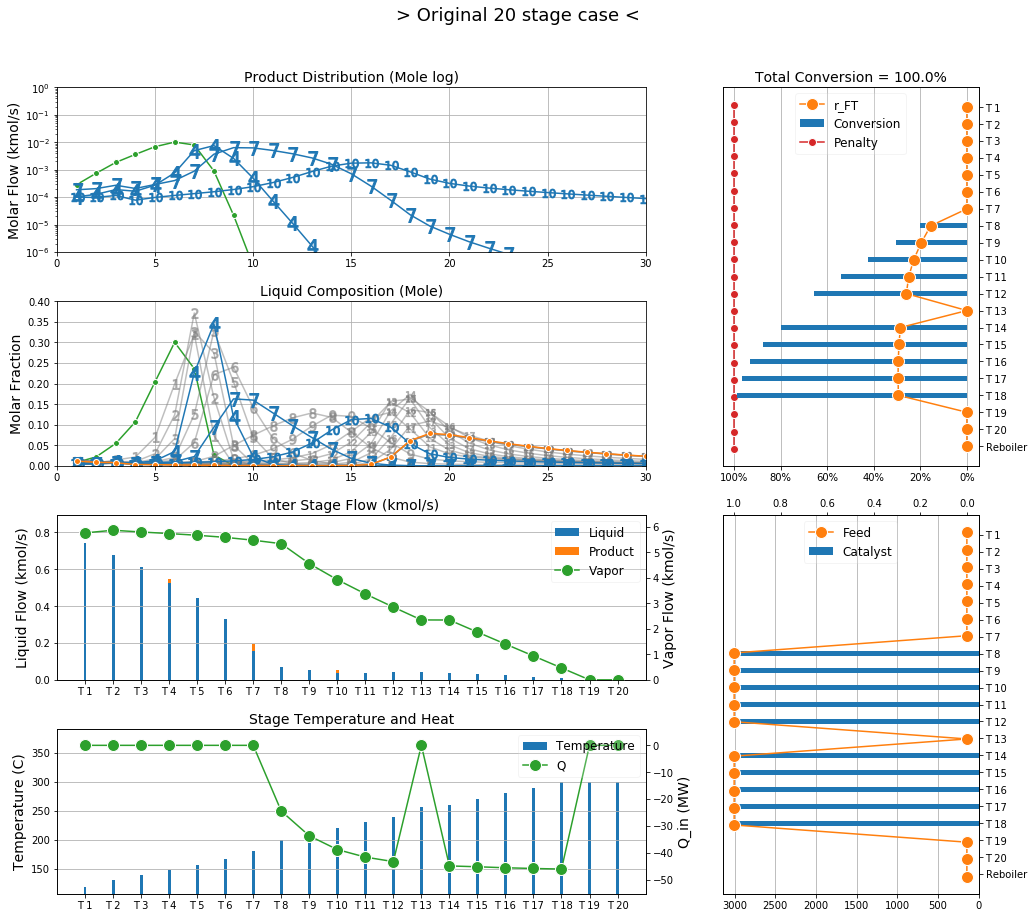

In [16]:
with HiddenLogs(log_text_dir,'w'):
    print('\n>','Original 20 stage case')
    print('-'*108)
    beautify(pe,model)
    check_product_spec(model)
    log_now()

plot_distribution(model,pdf,'Original 20 stage case')

# Optimization Input

**Parameters:**
* Stage Temperature
    * Rectifying section: 200C - 300C
    * Stripping section: 200C - 300C
* Reflux
    * Distillate / (Distillate + Reflux): 0.5 - 0.05, Refulx Ratio: 1 - 19
* Side-draw ratio
    * PR_L: 0 - 1

**Constraints:**
* Product
    * Distillate: C5~C7 >= 0.75
    * Gasoline: C8~C12 >= 0.75
    * Diesel: C13~C18 >= 0.6
    * Heavy: C19+ >= 0.85
    
**Objective:**
* Max gasoline production

### Open up parameters

In [17]:
for j in model.TRAY_reactive:
    model.reactive[j].T.setlb(200+273.15)
    model.reactive[j].T.setub(300+273.15)
    
model.condenser.PR_L.unfix()
model.condenser.PR_L.setlb(0.05)
model.condenser.PR_L.setub(0.5)

In [18]:
model.P_tray['4','intermediate'].unfix()
model.P_tray['7','gasoline'].unfix()
model.P_tray['10','diesel'].unfix()

### Constraints

In [19]:
model.quality_spec = pe.Param(m.PRODUCT,initialize={\
                    'naphtha':0.75,'gasoline':0.75,'diesel':0.6,'heavy':0.85},mutable=True)

In [20]:
def product_spec_rule(model,p):
    if p == 'intermediate':
        return pe.Constraint.Skip
    return sum(model.x_P_dry[i,p] for i in m.PRODUCT_cnumber[p]) >= model.quality_spec[p]
model.product_spec_con = pe.Constraint(m.PRODUCT,rule=product_spec_rule)

### Objective

In [21]:
model.del_component(model.obj)
model.obj = pe.Objective(expr = model.P_total['gasoline'] - sum(model.reactive[j].MPCC.pf for j in model.reactive)\
                                - model.reboiler.MPCC.pf, sense = pe.maximize)

In [22]:
results = opt.solve(model,tee=True)
update_dual(pe,model)

Ipopt 3.12.8: print_user_options=yes
linear_solver=ma86
linear_system_scaling =mc19
linear_scaling_on_demand =no
max_iter=7000
warm_start_init_point=yes
warm_start_bound_push=1e-20
warm_start_mult_bound_push=1e-20
mu_init=1e-06


List of user-set options:

                                    Name   Value                used
                linear_scaling_on_demand = no                    yes
                           linear_solver = ma86                  yes
                   linear_system_scaling = mc19                  yes
                                max_iter = 7000                  yes
                                 mu_init = 1e-06                 yes
                      print_user_options = yes                   yes
                   warm_start_bound_push = 1e-20                 yes
                   warm_start_init_point = yes                   yes
              warm_start_mult_bound_push = 1e-20                 yes

****************************************************

  68 -1.0517016e-01 1.76e+00 6.31e+02  -6.0 1.17e+03    -  2.36e-01 2.58e-01h  1
  69 -1.0579268e-01 1.09e+01 1.13e+02  -6.0 1.19e+03    -  2.65e-04 2.07e-01H  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70 -1.0555348e-01 3.68e+00 2.82e+02  -6.0 2.30e+03    -  5.19e-04 1.68e-01H  1
  71 -1.0561209e-01 8.69e+00 3.72e+02  -6.0 8.22e+02    -  1.00e+00 1.00e+00h  1
  72 -1.0551865e-01 7.35e-01 7.49e+01  -6.0 2.43e+02    -  1.00e+00 1.00e+00h  1
  73 -1.0551457e-01 9.75e-03 2.72e-01  -6.0 2.78e+01    -  1.00e+00 1.00e+00h  1
  74 -1.0551429e-01 3.85e-05 6.77e-05  -6.0 1.43e+00    -  1.00e+00 1.00e+00h  1
  75 -1.0551429e-01 3.64e-10 6.55e-10  -6.0 4.37e-03    -  1.00e+00 1.00e+00h  1
  76 -1.0567371e-01 5.31e-01 2.53e+01  -9.0 1.97e+02    -  8.41e-01 8.83e-01f  1
  77 -1.0566349e-01 3.48e-01 1.59e+01  -9.0 2.65e+01    -  7.47e-01 3.48e-01h  1
  78 -1.0565214e-01 1.59e-01 1.16e+01  -9.0 1.72e+01    -  9.59e-01 5.48e-01h  1
  79 -1.0564591e-01 6.27e-02


> Optimized Product Side Draw
------------------------------------------------------------------------------------------------------------
Here comes the result:
------------------------------------------------------------------------------------------------------------
stages		T	Q						V_Prod	L_out	L_Prod		W
Condenser	30.00	-162.						2.1132	0.9770	0.0913		2.3384

stages		T	Q	r_FT	Conv%	F	cat		V_out	L_out	L_Prod		P_VLE
NON--[1]	132.4	0.000	0.0000	0.000	0.00	0.000		5.5201	1.2093	0.0000		20.000
NON--[2]	147.6	0.000	0.0000	0.000	0.00	0.000		5.7524	1.1552	0.0000		20.000
NON--[3]	158.2	0.000	0.0000	0.000	0.00	0.000		5.6983	1.1103	0.0000		20.000
NON--[4]	166.7	0.000	0.0000	0.000	0.00	0.000		5.6534	1.0491	0.0000		20.000
NON--[5]	175.0	0.000	0.0000	0.000	0.00	0.000		5.5922	0.9481	0.0000		20.000
NON--[6]	185.5	0.000	0.0000	0.000	0.00	0.000		5.4912	0.7685	0.0000		20.000
NON--[7]	202.5	0.000	0.0000	0.000	0.00	0.000		5.3116	0.4073	0.1056		20.000
React[8]	229.5	-32.2	0.2554	0.393	1.00	3000.		5.05

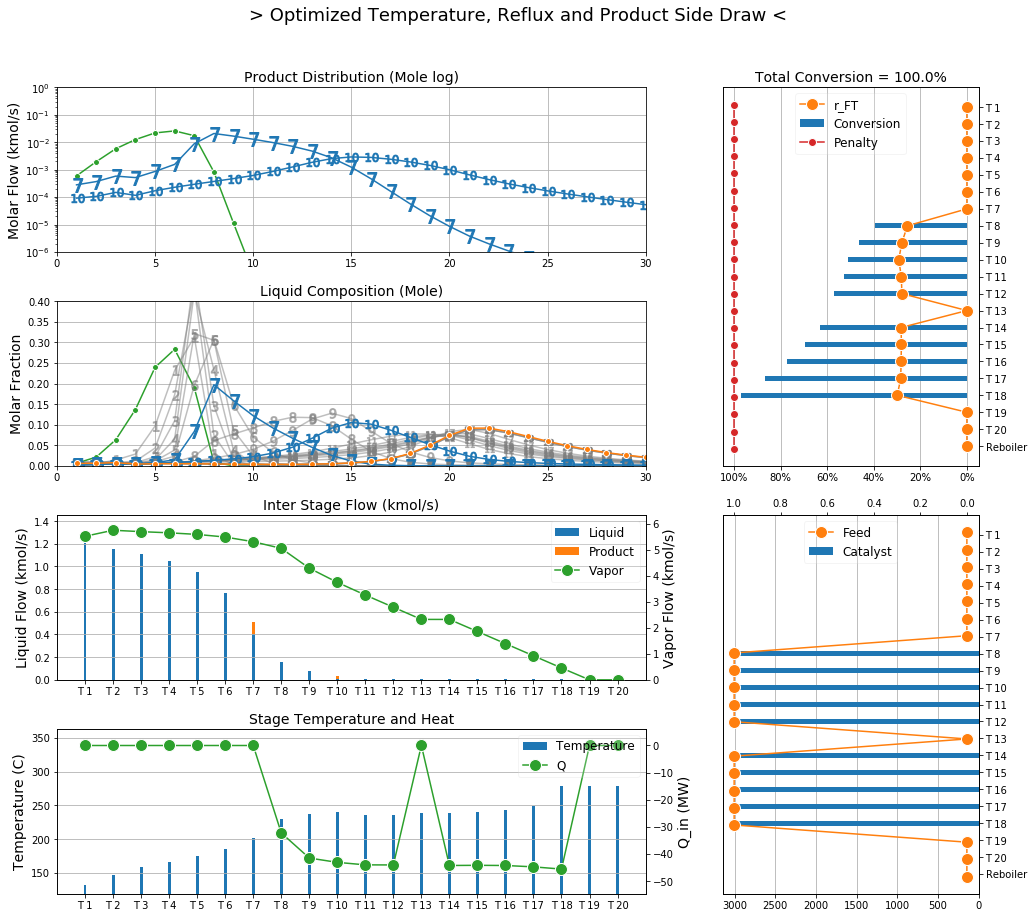

In [23]:
with HiddenLogs(log_text_dir):
    print('\n>','Optimized Product Side Draw')
    print('-'*108)
    beautify(pe,model)
    check_product_spec(model)
    log_now()

plot_distribution(model,pdf,'Optimized Temperature, Reflux and Product Side Draw')

# Open up product mixing and match

In [24]:
# model.P_tray[:,:].unfix();

In [25]:
# results = opt.solve(model,tee=True)
# update_dual(pe,model)

In [26]:
# plot_distribution(model)

# Open up feed allocation

**Parameters:**
* Stage Temperature
    * Rectifying section: 200C - 300C
    * Stripping section: 200C - 300C
* Reflux
    * Distillate / (Distillate + Reflux): 0.5 - 0.05, Refulx Ratio: 1 - 19
* Side-draw
    * PR_L: 0 - 1
    
* Feed
    * F: 0 - 3

**Constraints:**
* Product
    * Distillate: C5~C7 >= 0.75
    * Gasoline: C8~C12 >= 0.75
    * Diesel: C13~C18 >= 0.6
    * Heavy: C19+ >= 0.85
    
* Total feed
    * Total feed = 10 kmol/s
    
**Objective:**
* Max gasoline production

In [27]:
# for j in model.reactive:
#     model.reactive[j].F.unfix()
#     model.reactive[j].F.setlb(0)
#     model.reactive[j].F.setub(10)

In [28]:
# model.total_feed_con = pe.ConstraintList()

In [29]:
# model.total_feed_con.add(expr = sum(model.reactive[j].F for j in model.reactive) == 10);

In [30]:
# results = opt.solve(model,tee=True)
# update_dual(pe,model)

In [31]:
# with HiddenLogs(log_text_dir):
#     print('\n>','Optimized Feed Amount and Location')
#     print('-'*108)
#     beautify(pe,model)
#     see_product(model)
#     log_now()

# plot_distribution(model,pdf,'Optimized Feed Amount and Location')

# Open up catalyst allocation ( = TOTAL reconstruction, long wait time)

**Parameters:**
* Stage Temperature
    * Rectifying section: 200C - 300C
    * Stripping section: 200C - 300C
* Reflux
    * Distillate / (Distillate + Reflux): 0.5 - 0.05, Refulx Ratio: 1 - 19
* Side-draw
    * PR_L: 0 - 1
    
* Feed
    * F: 0 - 3
        
* Catalyst
    * cat: 0 - 10000

**Constraints:**
* Product
    * Distillate: C5~C7 >= 0.75
    * Gasoline: C8~C12 >= 0.75 / 0.8
    * Diesel: C13~C18 >= 0.6
    * Heavy: C19+ >= 0.85
    
* Total feed
    * sum feed = 10 kmol/s
    
* Total catalyst
    * sum cat = 30000 kg
    
**Objective:**
* Max gasoline production

In [32]:
# for j in model.reactive:
#     model.reactive[j].cat.unfix()
#     model.reactive[j].cat.setlb(0)
#     model.reactive[j].cat.setub(30000)

In [33]:
# model.total_cat_con = pe.ConstraintList()

In [34]:
# model.total_cat_con.add(expr = sum(model.reactive[j].cat for j in model.reactive) == 10*3000);

In [35]:
# results = opt.solve(model,tee=True)
# update_dual(pe,model)

In [36]:
# with HiddenLogs(log_text_dir):
#     print('\n>','Optimized Catalyst Amount and Location')
#     print('-'*108)
#     beautify(pe,model)
#     see_product(model)
#     log_now()

# plot_distribution(model,pdf,'Optimized Catalyst Amount and Location')

In [37]:
pdf.close()

In [38]:
# with open('./log/model/{}.pickle'.format(logname),'wb') as f:
#     dill.dump(model,f)

In [39]:
# for j in model.TRAY_reactive:
#     print('stage',j,'\n')
#     print('Total Flow\t{}'.format(model.reactive[j].F.value + sum(model.reactive[j].r_total_comp[i].value for i in m.COMP_TOTAL)))
#     for i in m.COMP_TOTAL:
#         if i in m.COMP_FEED:
#             print('{}\t\t{}'.format(i,model.reactive[j].F.value*model.reactive[j].z[i].value + model.reactive[j].r_total_comp[i].value))
#         else:
#             print('{}\t\t{}'.format(i,model.reactive[j].r_total_comp[i].value))